# Conditional GLOW for Cell Data Generation

In [7]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Create output directory
os.makedirs("generated", exist_ok=True)

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# %% [markdown]
# ## 2. Load and Preprocess

# %%
def load_and_preprocess_data(data_path='input/ML_data.csv'):
    df = pd.read_csv(data_path).drop(columns=['Samples'])
    df = df[~df['Cell_type'].isin(['Unknown'])]

    feature_names = df.columns.drop('Cell_type')
    le = LabelEncoder()
    df['Cell_type'] = le.fit_transform(df['Cell_type'])
    label_names = le.classes_
    num_classes = len(label_names)

    y = df['Cell_type'].values
    X = df.drop(columns=['Cell_type']).values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)

    return X, y, X_scaled, scaler, le, label_names, feature_names, num_classes, train_loader, val_loader

X, y, X_scaled, scaler, le, label_names, feature_names, num_classes, train_loader, val_loader = load_and_preprocess_data()
input_dim = X.shape[1]
print(f"Input dimension: {input_dim}, Number of classes: {num_classes}")

# %% [markdown]
# ## 3. Model Components

# %%
import torch.nn as nn
import torch.nn.utils.spectral_norm as spectral_norm

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.net = nn.Sequential(
            spectral_norm(nn.Linear(in_features, hidden_features)),  # Spectral Norm added
            nn.SiLU(),
            nn.LayerNorm(hidden_features),
            spectral_norm(nn.Linear(hidden_features, hidden_features)),  # Spectral Norm added
            nn.SiLU(),
            spectral_norm(nn.Linear(hidden_features, out_features)),  # Spectral Norm added
        )
    
    def forward(self, x):
        return self.net(x)

class ActNorm(nn.Module):
    def __init__(self, features, scale=1.0):
        super().__init__()
        self.initialized = False
        self.scale = scale
        self.register_parameter("bias", nn.Parameter(torch.zeros(features)))
        self.register_parameter("logs", nn.Parameter(torch.zeros(features)))

    def initialize(self, x):
        with torch.no_grad():
            mean = x.mean(0)
            std = x.std(0)
            self.bias.data.copy_(-mean)
            self.logs.data.copy_(torch.log(self.scale / (std + 1e-6)))
        self.initialized = True

    def forward(self, x):
        if not self.initialized:
            self.initialize(x)
        z = (x + self.bias) * torch.exp(self.logs)
        return z, self.logs.sum()

    def inverse(self, z):
        return (z * torch.exp(-self.logs)) - self.bias

class InvertibleLinear(nn.Module):
    def __init__(self, dim):
        super().__init__()
        W = torch.nn.init.orthogonal_(torch.randn(dim, dim))
        P, L, U = torch.lu_unpack(*W.lu())
        self.register_buffer('P', P)
        self.L = nn.Parameter(L)
        self.S = nn.Parameter(U.diag())
        self.U = nn.Parameter(torch.triu(U, diagonal=1))

    def _assemble_W(self):
        L = torch.tril(self.L, -1) + torch.eye(self.L.size(0), device=self.L.device)
        U = torch.triu(self.U, 1) + torch.diag(self.S)
        return self.P @ L @ U

    def forward(self, x):
        W = self._assemble_W()
        return x @ W, torch.sum(torch.log(torch.clamp(torch.abs(self.S), min=1e-6)))

    def inverse(self, z):
        W = self._assemble_W()
        return z @ torch.inverse(W)

class AffineCoupling(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask, class_embedding):
        super().__init__()
        self.mask = mask
        self.embedding = class_embedding
        self.shared_net = MLP(input_dim + 8, hidden_dim, input_dim * 2)

    def forward(self, x, y):
        x_masked = x * self.mask
        y_embed = self.embedding(y)
        x_cat = torch.cat([x_masked, y_embed], dim=1)
        scale_translate = self.shared_net(x_cat)
        scale, translate = scale_translate.chunk(2, dim=1)
        scale = scale * (1 - self.mask)
        translate = translate * (1 - self.mask)
        y_out = x_masked + (1 - self.mask) * (x * torch.exp(scale) + translate)
        return y_out, scale.sum(1)

    def inverse(self, y, label):
        y_masked = y * self.mask
        y_embed = self.embedding(label)
        y_cat = torch.cat([y_masked, y_embed], dim=1)
        scale_translate = self.shared_net(y_cat)
        scale, translate = scale_translate.chunk(2, dim=1)
        scale = scale * (1 - self.mask)
        translate = translate * (1 - self.mask)
        x = y_masked + (1 - self.mask) * (y - translate) * torch.exp(-scale)
        return x



class GlowStep(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask, class_embedding):
        super().__init__()
        self.actnorm = ActNorm(input_dim)
        self.invconv = InvertibleLinear(input_dim)
        self.coupling = AffineCoupling(input_dim, hidden_dim, mask, class_embedding)


    def forward(self, x, y):
        x, ldj1 = self.actnorm(x)
        x, ldj2 = self.invconv(x)
        x, ldj3 = self.coupling(x, y)
        return x, ldj1 + ldj2 + ldj3

    def inverse(self, z, y):
        z = self.coupling.inverse(z, y)
        z = self.invconv.inverse(z)
        z = self.actnorm.inverse(z)
        return z

class ConditionalGLOW(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_flow_steps, num_classes, class_embedding_dim=8):
        super().__init__()
        self.class_embedding = nn.Embedding(num_classes, class_embedding_dim)
        self.flow_steps = nn.ModuleList()
        
        # Create different mask patterns for better expressivity
        for i in range(n_flow_steps):
            if i % 3 == 0:  # Alternating mask patterns
                mask = torch.zeros(input_dim).to(device)
                mask[::2] = 1  # Even indices
            elif i % 3 == 1:
                mask = torch.zeros(input_dim).to(device)
                mask[1::2] = 1  # Odd indices
            else:
                mask = torch.zeros(input_dim).to(device)
                mask[i % input_dim::max(1, input_dim // 4)] = 1  # Mixed pattern
                
            self.flow_steps.append(
                GlowStep(input_dim, hidden_dim, mask, self.class_embedding)
            )

    def forward(self, x, y):
        log_det = 0
        for step in self.flow_steps:
            x, ldj = step(x, y)
            log_det += ldj
        return x, log_det

    def inverse(self, z, y):
        for step in reversed(self.flow_steps):
            z = step.inverse(z, y)
        return z

# %% [markdown]
# ## 4. Training

# %%
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
import numpy as np

# Loss functions for additional metrics
def cosine_similarity_loss(real, generated):
    return 1 - F.cosine_similarity(real, generated).mean()

def mean_absolute_error_loss(real, generated):
    return F.l1_loss(real, generated).mean()

def mean_squared_error_loss(real, generated):
    return F.mse_loss(real, generated).mean()

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Initialize the model and optimizer
hidden_dim = 128
n_flow_steps = 16
model = ConditionalGLOW(input_dim, hidden_dim, n_flow_steps, num_classes).to(device)
#model = torch.compile(model)  # Compiles the model with TorchDynamo for CUDA graphs and speedup
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Set up the learning rate scheduler
# Replace your current optimizer and scheduler with:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

# Modify the training loop to include the scheduler step
def train(model, train_loader, optimizer, scheduler, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        total_cosine_loss = 0
        total_mse_loss = 0
        total_mae_loss = 0
        total_nll_loss = 0
        total_samples = 0
        
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            z, log_det = model(x_batch, y_batch)
            log_prob = -0.5 * torch.sum(z ** 2, dim=1) - 0.5 * input_dim * np.log(2 * np.pi)
            nll_loss = -(log_prob + log_det).mean()
            
            # Compute additional loss metrics
            mse_loss = mean_squared_error_loss(x_batch, z)  # MSE between original and generated data
            mae_loss = mean_absolute_error_loss(x_batch, z)  # MAE between original and generated data
            cosine_loss = cosine_similarity_loss(x_batch, z)  # Cosine similarity between original and generated data

            # Total loss is a combination of all metrics
            total_loss = nll_loss + mse_loss + mae_loss + cosine_loss

            # Backward pass and optimization
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            
            # Accumulate the metrics for reporting
            total_samples += x_batch.size(0)
            total_nll_loss += nll_loss.item() * x_batch.size(0)
            total_mse_loss += mse_loss.item() * x_batch.size(0)
            total_mae_loss += mae_loss.item() * x_batch.size(0)
            total_cosine_loss += cosine_loss.item() * x_batch.size(0)
        
        # Compute average losses
        avg_nll_loss = total_nll_loss / total_samples
        avg_mse_loss = total_mse_loss / total_samples
        avg_mae_loss = total_mae_loss / total_samples
        avg_cosine_loss = total_cosine_loss / total_samples

        print(f"Epoch {epoch+1}/{num_epochs}, NLL Loss: {avg_nll_loss:.4f}, MSE Loss: {avg_mse_loss:.4f}, "
              f"MAE Loss: {avg_mae_loss:.4f}, Cosine Similarity Loss: {avg_cosine_loss:.4f}")

        # Step the scheduler after every epoch
        scheduler.step()

# Train the model
train(model, train_loader, optimizer, scheduler, num_epochs=300)

#torch.save(model.state_dict(), "generated/glow_model.pt")

Using device: cuda
Input dimension: 89, Number of classes: 4
Epoch 1/300, NLL Loss: 142.3062, MSE Loss: 1.9259, MAE Loss: 1.0863, Cosine Similarity Loss: 0.9822
Epoch 2/300, NLL Loss: 116.4859, MSE Loss: 1.8919, MAE Loss: 1.0802, Cosine Similarity Loss: 0.9600
Epoch 3/300, NLL Loss: 105.7462, MSE Loss: 1.8385, MAE Loss: 1.0656, Cosine Similarity Loss: 0.9317
Epoch 4/300, NLL Loss: 100.7291, MSE Loss: 1.8282, MAE Loss: 1.0640, Cosine Similarity Loss: 0.9169
Epoch 5/300, NLL Loss: 97.3451, MSE Loss: 1.7912, MAE Loss: 1.0529, Cosine Similarity Loss: 0.8951
Epoch 6/300, NLL Loss: 93.6832, MSE Loss: 1.7263, MAE Loss: 1.0356, Cosine Similarity Loss: 0.8681
Epoch 7/300, NLL Loss: 90.2046, MSE Loss: 1.7233, MAE Loss: 1.0341, Cosine Similarity Loss: 0.8637
Epoch 8/300, NLL Loss: 86.4068, MSE Loss: 1.7087, MAE Loss: 1.0308, Cosine Similarity Loss: 0.8565
Epoch 9/300, NLL Loss: 82.9227, MSE Loss: 1.7067, MAE Loss: 1.0299, Cosine Similarity Loss: 0.8567
Epoch 10/300, NLL Loss: 79.3265, MSE Loss: 1

In [ ]:
torch.save(model.state_dict(), "generated/glow_model.pt")


NameError: name 'epoch' is not defined

# 5. Generate and Visualize

In [12]:
def generate_synthetic_data(model, scaler, le, samples_per_class_dict):
    model.eval()
    zs, labels = [], []

    for class_name, n_samples in samples_per_class_dict.items():
        class_idx = le.transform([class_name])[0]
        z = torch.randn(n_samples, input_dim).to(device)
        y = torch.full((n_samples,), class_idx, dtype=torch.long).to(device)
        x_fake = model.inverse(z, y).detach().cpu().numpy()
        zs.append(x_fake)
        labels.extend([class_idx] * n_samples)

    X_fake = np.vstack(zs)
    y_fake = np.array(labels)
    X_fake_rescaled = scaler.inverse_transform(X_fake)

    df_fake = pd.DataFrame(X_fake_rescaled, columns=feature_names)
    df_fake["Cell_type"] = le.inverse_transform(y_fake)
    df_fake.to_csv("generated/fake_data.csv", index=False)
    print("✅ Saved synthetic data to 'generated/fake_data.csv'")
    return df_fake

samples_per_class_dict = {
    "PreB": 0,
    "B": 250,
    "T": 250,
    "PreT": 250
}

df_fake = generate_synthetic_data(model, scaler, le, samples_per_class_dict)

X_fake = scaler.transform(df_fake[feature_names])
y_fake = le.transform(df_fake["Cell_type"])



✅ Saved synthetic data to 'generated/fake_data.csv'


/home/thomas/miniconda3/envs/DeepN/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


/home/thomas/miniconda3/envs/DeepN/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/thomas/miniconda3/envs/DeepN/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


✅ MMD (RBF, γ=1.0) = 0.00294
🌊 Avg. 1D Wasserstein Distance = 0.19671
🧭 Mean Cosine Similarity = 0.00454
🔍 k-NN Realism Score (k=5) = 0.00107


<Figure size 1400x1000 with 0 Axes>

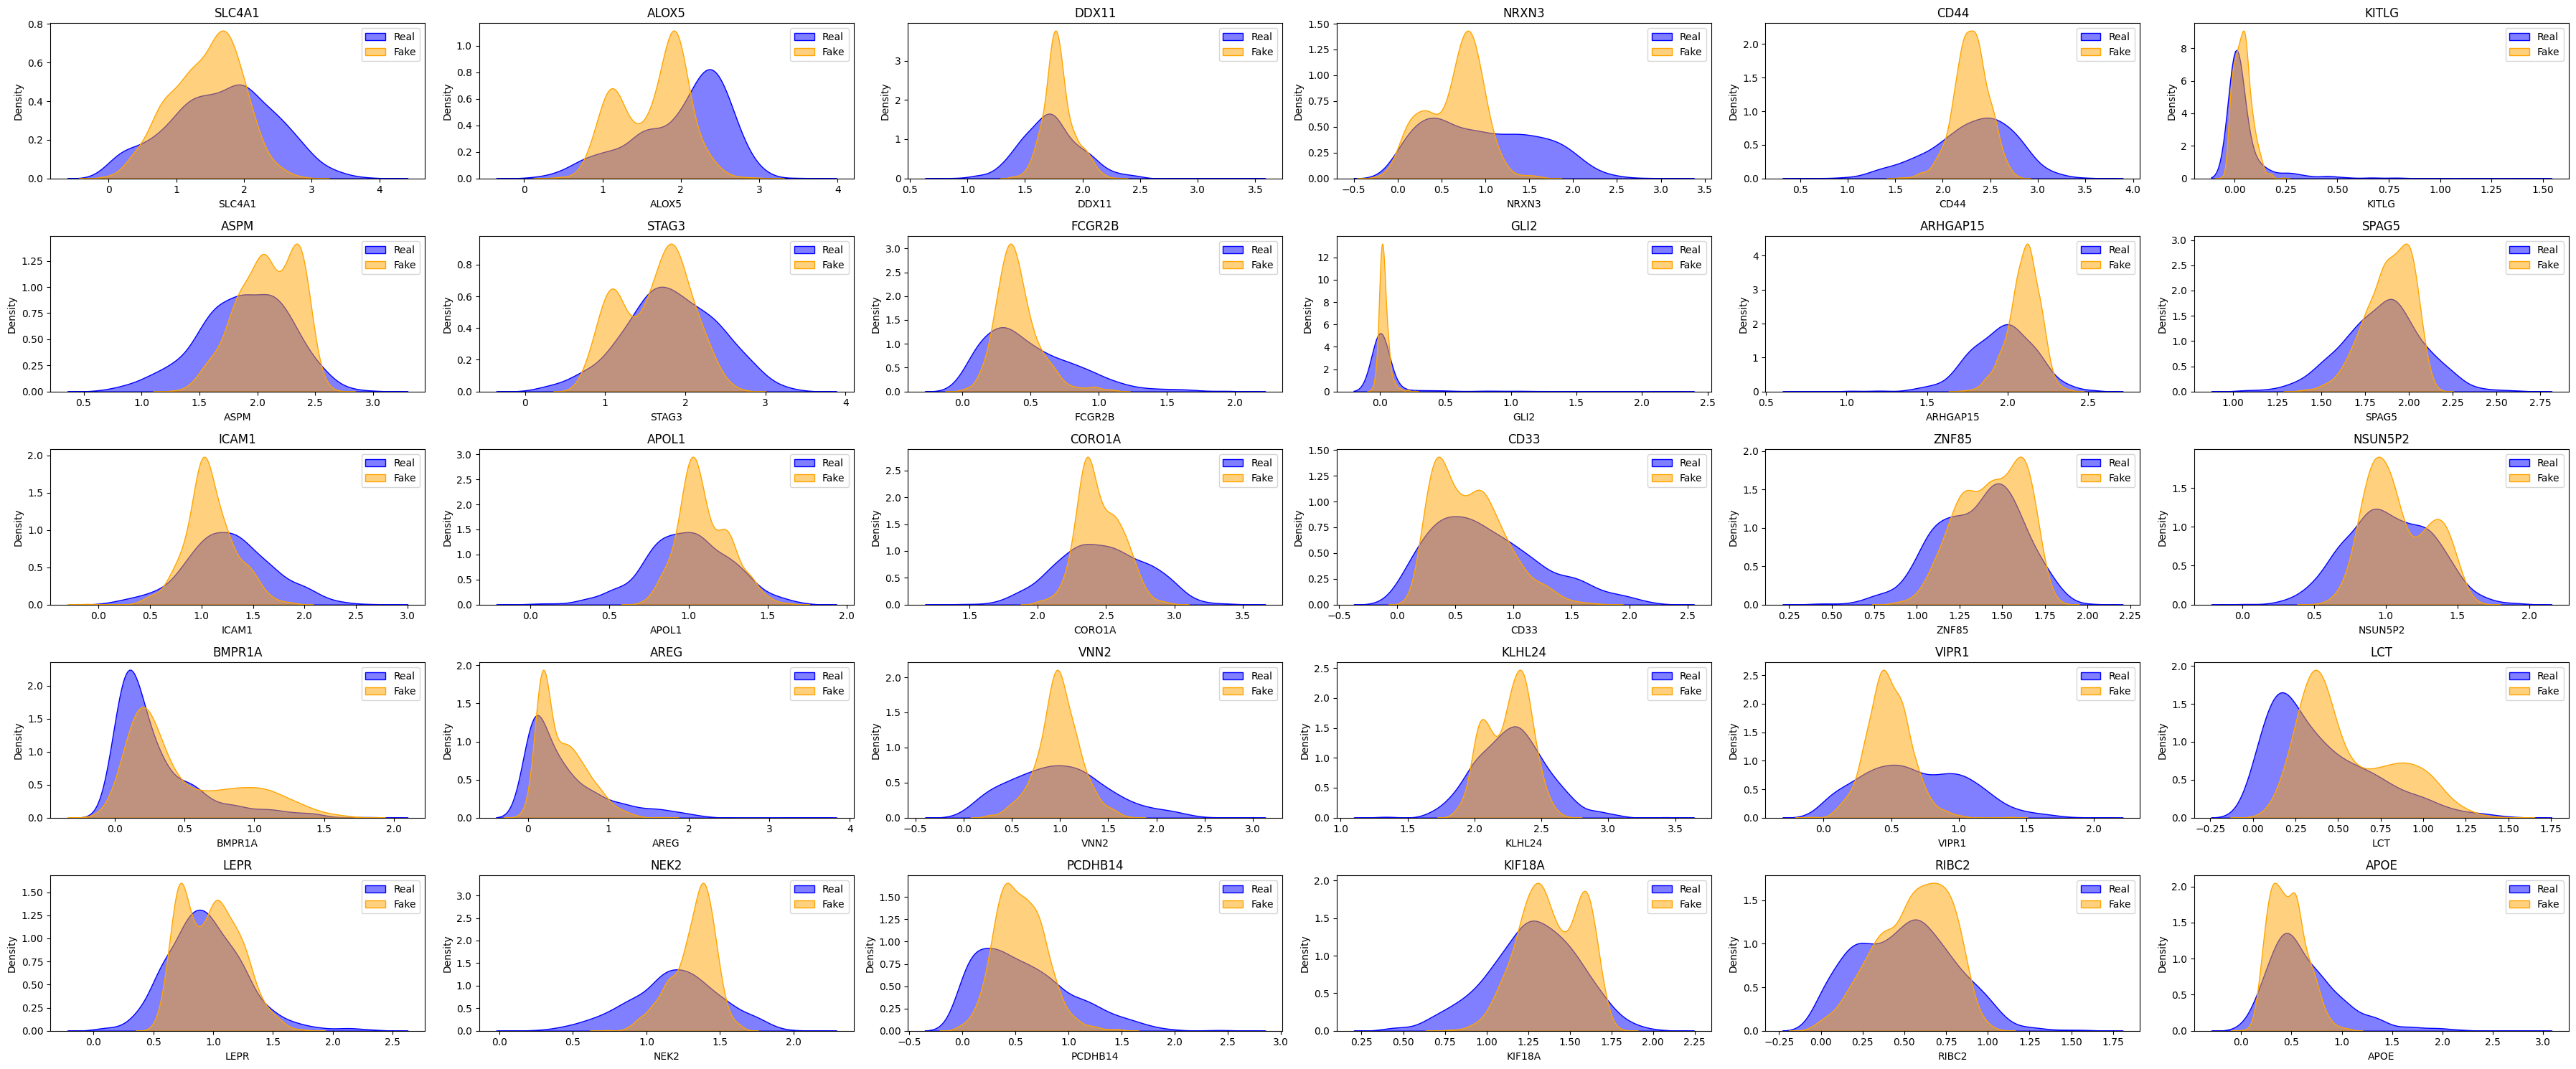

✅ Feature distribution grid saved as 'generated/feature_distributions_grid.png'


In [10]:
# %% [markdown]
# ## 7. Visualization: PCA Per Class + Feature Distribution

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pca_per_class(X_real, y_real, X_fake, y_fake, class_names, scaler, label_encoder):
    pca = PCA(n_components=2)
    for i, class_name in enumerate(class_names):
        real_mask = y_real == i
        fake_mask = y_fake == i

        if np.sum(real_mask) == 0 or np.sum(fake_mask) == 0:
            continue

        Xr = X_real[real_mask]
        Xf = X_fake[fake_mask]
        X_combined = np.vstack([Xr, Xf])
        X_pca = pca.fit_transform(X_combined)

        Xr_pca = X_pca[:len(Xr)]
        Xf_pca = X_pca[len(Xr):]

        plt.figure(figsize=(14, 10))
        plt.scatter(Xr_pca[:, 0], Xr_pca[:, 1], alpha=0.6, label="Real", c='blue')
        plt.scatter(Xf_pca[:, 0], Xf_pca[:, 1], alpha=0.6, label="Fake", c='orange')
        plt.title(f"PCA: {class_name}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"generated/pca_{class_name}.png")
        plt.close()

def plot_feature_distributions_grid(df_real, df_fake, features, max_features=24, n_cols=4):
    selected_features = features[:max_features]
    n_feats = len(selected_features)
    n_rows = (n_feats + n_cols - 1) // n_cols
    plt.figure(figsize=(14, 10))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 3))
    axes = axes.flatten()

    for idx, feature in enumerate(selected_features):
        ax = axes[idx]
        sns.kdeplot(data=df_real, x=feature, label="Real", fill=True, color="blue", alpha=0.5, ax=ax)
        sns.kdeplot(data=df_fake, x=feature, label="Fake", fill=True, color="orange", alpha=0.5, ax=ax)
        ax.set_title(feature)
        ax.legend()

    # Hide any empty subplots
    for i in range(n_feats, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig("generated/feature_distributions_grid.png")
    plt.show()
    plt.close()
    print(f"✅ Feature distribution grid saved as 'generated/feature_distributions_grid.png'")



def plot_feature_distributions(X_real_df, X_fake_df, features, class_names):
    for feature in features:
        plt.figure(figsize=(14, 10))
        sns.kdeplot(data=X_real_df, x=feature, label="Real", fill=True, color="blue", alpha=0.5)
        sns.kdeplot(data=X_fake_df, x=feature, label="Fake", fill=True, color="orange", alpha=0.5)
        plt.title(f"Feature Distribution: {feature}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"generated/feature_dist_{feature}.png")
        plt.show()
        plt.close()

from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

def compute_mmd_rbf(X_real, X_fake, gamma=1.0):
    """Compute Maximum Mean Discrepancy (MMD) between real and fake using RBF kernel."""
    XX = rbf_kernel(X_real, X_real, gamma=gamma)
    YY = rbf_kernel(X_fake, X_fake, gamma=gamma)
    XY = rbf_kernel(X_real, X_fake, gamma=gamma)

    mmd = XX.mean() + YY.mean() - 2 * XY.mean()
    print(f"✅ MMD (RBF, γ={gamma}) = {mmd:.5f}")
    return mmd

from scipy.stats import wasserstein_distance

def compute_avg_wasserstein_distance(df_real, df_fake, feature_names):
    distances = []
    for feature in feature_names:
        d = wasserstein_distance(df_real[feature], df_fake[feature])
        distances.append(d)
    avg_wass = np.mean(distances)
    print(f"🌊 Avg. 1D Wasserstein Distance = {avg_wass:.5f}")
    return avg_wass

from sklearn.metrics.pairwise import cosine_similarity

def compute_mean_cosine_similarity(X_real, X_fake, n_samples=1000):
    """Compute mean cosine similarity between randomly paired real and fake samples."""
    n = min(len(X_real), len(X_fake), n_samples)
    Xr = X_real[:n]
    Xf = X_fake[:n]
    similarities = cosine_similarity(Xr, Xf)
    mean_cos_sim = np.mean(np.diag(similarities))
    print(f"🧭 Mean Cosine Similarity = {mean_cos_sim:.5f}")
    return mean_cos_sim

from sklearn.neighbors import NearestNeighbors

def compute_knn_realism_score(X_real, X_fake, k=5):
    """Compute realism score: fraction of real samples in k-NN of each fake point."""
    X = np.vstack([X_real, X_fake])
    y = np.array([1]*len(X_real) + [0]*len(X_fake))  # 1=real, 0=fake
    knn = NearestNeighbors(n_neighbors=k+1)  # +1 because the point itself is included
    knn.fit(X)
    
    indices = knn.kneighbors(X_fake, return_distance=False)[:, 1:]  # exclude self
    neighbor_labels = y[indices]
    realism_scores = neighbor_labels.mean(axis=1)
    avg_realism = realism_scores.mean()
    print(f"🔍 k-NN Realism Score (k={k}) = {avg_realism:.5f}")
    return avg_realism

# Prepare for plotting
df_real = pd.DataFrame(scaler.inverse_transform(X_scaled), columns=feature_names)
df_real["Cell_type"] = le.inverse_transform(y)
df_fake = pd.read_csv("generated/fake_data.csv")
X_real = scaler.transform(df_real[feature_names])
y_real = le.transform(df_real["Cell_type"])
X_fake = scaler.transform(df_fake[feature_names])
y_fake = le.transform(df_fake["Cell_type"])

mmd = compute_mmd_rbf(X_scaled, X_fake)
compute_avg_wasserstein_distance(df_real, df_fake, feature_names)
compute_mean_cosine_similarity(X_real, X_fake)
compute_knn_realism_score(X_real, X_fake, k=5)

plot_pca_per_class(X_scaled, y, X_fake, y_fake, label_names, scaler, le)
#plot_feature_distributions(df_real, df_fake, feature_names, label_names)
plot_feature_distributions_grid(df_real, df_fake, feature_names, max_features=30, n_cols=6)